In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import src.CasualInfer.casual_infer_utils as pu
sns.set()  # set the style

## SETUP

##### A. Background:

- Some Groupon deals have a minimal requirement, e.g., as shown in the picture above, the deal only works when there are at least 100 committed buyers.

- Groups:
    - Control group: deals without the minimal requirement
    - Treatment group: deals with minimal requirement

##### B. Question at Hand
 - Does having the minimal requirement affect the deal outcomes, such as revenue, quantity sold, and Facebook likes received?


##### C. Need for propensity matching 

- Unequal distribution of Treatment in Outcomes
  - High revenue and low revenue 
  - High Quantity sold vs Low Quantity sold
  - High Facebook likes received vs Low Facebook likes received 
  
##### D. Features to be used

What features to select: As we will illustrate later, the following features/variables should be excluded:
- features/variables that predict treatment status perfectly, such as min_req feature, which the treatment feature is directly derived from (see the code notebook for the result of adding min_req).
- features/variables that may be affected by the treatment

## 0.1. Read the groupon data

In [2]:
df = pd.read_csv('./data/groupon.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   deal_id          710 non-null    object
 1   start_date       710 non-null    object
 2   min_req          710 non-null    int64 
 3   treatment        710 non-null    int64 
 4   prom_length      710 non-null    int64 
 5   price            710 non-null    int64 
 6   discount_pct     710 non-null    int64 
 7   coupon_duration  710 non-null    int64 
 8   featured         710 non-null    int64 
 9   limited_supply   710 non-null    int64 
 10  fb_likes         710 non-null    int64 
 11  quantity_sold    710 non-null    int64 
 12  revenue          710 non-null    int64 
dtypes: int64(11), object(2)
memory usage: 72.2+ KB


## 0.2. Extract features to be used for propensity score matching 

In [3]:
features_for_model = ['prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured', 'limited_supply']

## 0.3. Initialize propensity modeling class for the data

In [4]:
pu_cls = pu.PropensityScoreAnalyzer(data=df, index='deal_id', features=features_for_model)

20/03//2024 01:29:1710921585 PM - DEBUG - PropensityScoreAnalyzer: Initialized PropensityScoreAnalyzer class


In [5]:
pu_cls.X

,prom_length,price,discount_pct,coupon_duration,featured,limited_supply
0,4,99,51,185,1,1
1,2,95,41,9,0,1
2,3,25,50,38,0,1
3,3,50,50,369,0,1
4,4,25,52,185,0,1
...,...,...,...,...,...,...
705,5,45,54,164,0,1
706,8,149,67,52,0,1
707,4,159,60,29,0,1
708,4,19,51,187,0,1


In [6]:
pu_cls.y

0      1
1      1
2      1
3      1
4      1
      ..
705    0
706    0
707    0
708    0
709    0
Name: treatment, Length: 710, dtype: int64

## 1.1 Data Exploration of distances


In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

In [8]:
pu_cls_ps = pu_cls.calc_logistic_ps(pu_cls.X)
pu_cls_ps.head()

20/03//2024 01:29:1710921586 PM - INFO - PropensityScoreAnalyzer.calc_logistic_ps: Calculating logistic regression based propensity score


/Users/abhilashdhal/Desktop/data_science_projects/Data-Science-with-Python/src/CasualInfer/casual_infer_utils.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ps'] = model.predict_proba(self.X)[:,1]
/Users/abhilashdhal/Desktop/data_science_projects/Data-Science-with-Python/src/CasualInfer/casual_infer_utils.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ps_logit'] = df.ps.apply(lambda x: self.logit(x))


,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,ps,ps_logit
0,4,99,51,185,1,1,0.259192,-1.050170
1,2,95,41,9,0,1,0.230198,-1.207194
2,3,25,50,38,0,1,0.288405,-0.903144
3,3,50,50,369,0,1,0.511781,0.047131
4,4,25,52,185,0,1,0.325212,-0.729919


In [9]:
print(pu_cls.caliper)

20/03//2024 01:29:1710921587 PM - INFO - PropensityScoreAnalyzer.calc_logistic_ps: Calculating logistic regression based propensity score
0.03113485901968018


/opt/homebrew/anaconda3/envs/propensity/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
knn = NearestNeighbors(n_neighbors=10, radius=pu_cls.caliper, algorithm='ball_tree')
knn = knn.fit(pu_cls_ps[['ps']])
distances, indices = knn.kneighbors(pu_cls_ps[['ps']])
distances_plt = np.sort(distances, axis=0)
distances_plt = distances[:,1]

/opt/homebrew/anaconda3/envs/propensity/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Distance')

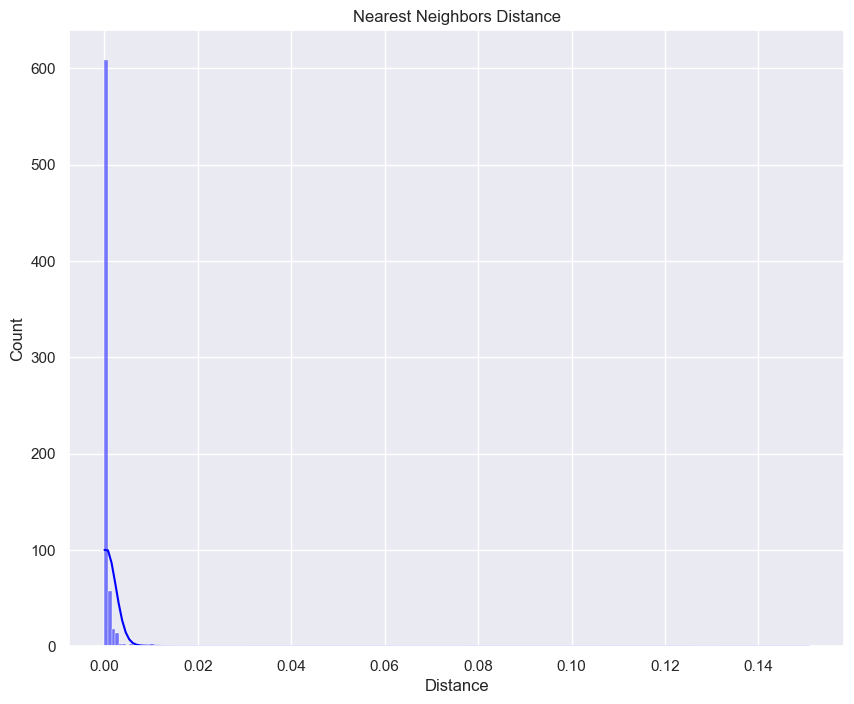

In [11]:

plt.figure(figsize=(10,8))
ax = sns.histplot(distances_plt, kde=True, bins=200, color='blue')
ax.set_title('Nearest Neighbors Distance')
ax.set_xlabel('Distance')


## 1.2. Perform matching

In [12]:
df_matched = pu_cls.make_matched_data()

20/03//2024 01:29:1710921589 PM - INFO - PropensityScoreAnalyzer.knn_matched: Starting KNN matching for propensity score calculation
20/03//2024 01:29:1710921589 PM - INFO - PropensityScoreAnalyzer.calc_logistic_ps: Calculating logistic regression based propensity score
total observations in treatment: 216
total matched observations in control: 171
20/03//2024 01:29:1710921589 PM - INFO - PropensityScoreAnalyzer.knn_matched: Finished KNN matching for propensity score calculation


/opt/homebrew/anaconda3/envs/propensity/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 1.3. Analysis of feature p-values before vs after matching in treatment and control

In [13]:
from numpy import mean
from numpy import var
from math import sqrt
 
# function to calculate Cohen's d for independent samples
def cohen_d(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = mean(d1), mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

## 1.3.1 Get consolidated stats dataframe 

In [14]:
all_stats_df = pu_cls.calc_stats(df_matched)

20/03//2024 01:29:1710921591 PM - INFO - PropensityScoreAnalyzer.calc_stats: Calculating statistics on ps matched data
20/03//2024 01:29:1710921591 PM - INFO - PropensityScoreAnalyzer.calc_stats: Calculating p_values before/after matching for prom_length feature using ttest_ind
20/03//2024 01:29:1710921591 PM - INFO - PropensityScoreAnalyzer.calc_stats: Calculating effect sizes before/after matching for prom_length feature using cohen_d method
20/03//2024 01:29:1710921591 PM - INFO - PropensityScoreAnalyzer.calc_stats: Calculating p_values before/after matching for price feature using ttest_ind
20/03//2024 01:29:1710921591 PM - INFO - PropensityScoreAnalyzer.calc_stats: Calculating effect sizes before/after matching for price feature using cohen_d method
20/03//2024 01:29:1710921591 PM - INFO - PropensityScoreAnalyzer.calc_stats: Calculating p_values before/after matching for discount_pct feature using ttest_ind
20/03//2024 01:29:1710921591 PM - INFO - PropensityScoreAnalyzer.calc_stat

## 1.3.2. Visualize Effect size using cohen's D between treatment and control groups before and after

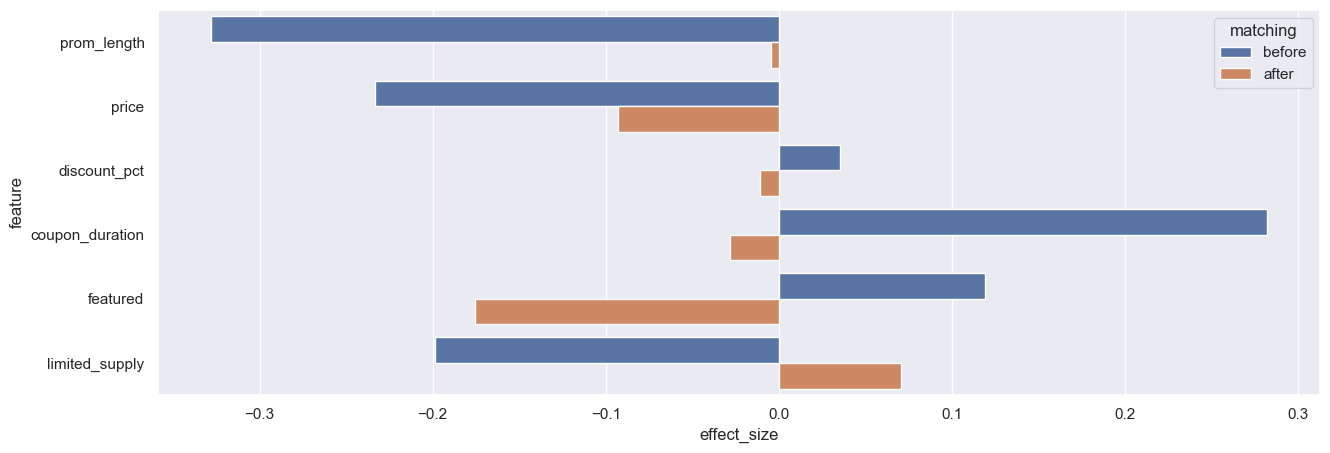

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(data=all_stats_df, x='effect_size', y='feature', hue='matching', orient='h')

## 1.3.3. Visualize P-value significance of t-test b/w treatment and control groups before and after

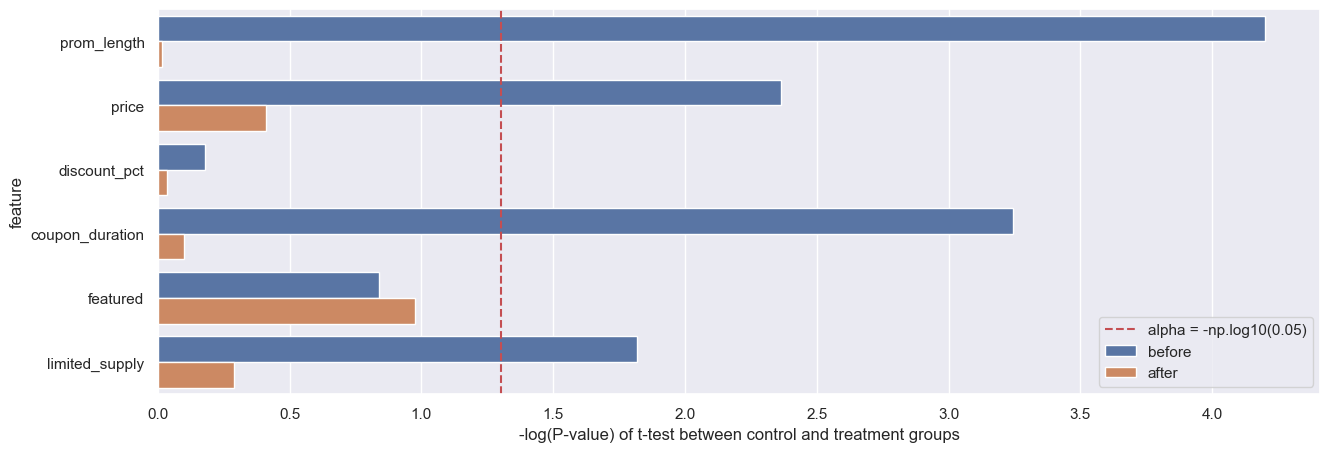

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(data=all_stats_df, x='log_P', y='feature', hue='matching', orient='h')
ax.set_xlabel('-log(P-value) of t-test between control and treatment groups')
ax.axvline(x=-np.log10(0.05), color='r', linestyle='--', label='alpha = -np.log10(0.05)')
ax.legend()

## 1.5 Effect of minimal requirements on deal outcomes

- Here we are interested in converting deal outcomes into binary variable based on some threshold 
- Find correct threshold for high and low values

## 1.5.1 Calculate ATE after converting continuous deal outcomes (revenue, fb_likes, quantity) to binary outcomes based on tukey's threshold

In [20]:
cols = ['revenue', 'fb_likes', 'quantity_sold']
ate_dict_lower = {}
ate_dict_upper = {}
for col in cols:
    matched_df_binary_upp = pu_cls.create_binary_outcome(df_matched, col, which_bound='upper')
    # matched_df_binary_low = pu_cls.create_binary_outcome(df_matched, col, which_bound='lower')
    merged_df_upp = pu_cls.create_merged_df(matched_df_binary_upp)
    # merged_df_low = pu_cls.create_merged_df(matched_df_binary_low)
    ate_dict_upper[col] = pu_cls.calc_ate(df_merged= merged_df_upp, col=col+'_binary')
    # ate_dict_lower[col] = pu_cls.calc_ate(df_merged= merged_df_low, col=col+'_binary')

In [18]:
ate_dict_lower

{'revenue': 0.04678362573099415,
 'fb_likes': 0.06432748538011696,
 'quantity_sold': 0.06432748538011696}

In [21]:
ate_dict_upper

{'revenue': 0.017543859649122806,
 'fb_likes': 0.03508771929824561,
 'quantity_sold': 0.023391812865497075}

## 1.5.2 Interpretation:

- Revenue: From deals with minimal requirements there is atleast a 2-4% increase compared to deals without minimal requirements

- FB likes: Deals with minimal requirements have atleast 4-6% increase in likes compared to deals without minimal requirements

- Quantity sold: Deals with minimal requirements show 2.5-6% increase in units sold compared to deals without minimal requirements

## 1.5.2 Visualize distribution of deal outcomes

/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_56411/1297715415.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(matched_df['revenue'])
/opt/homebrew/anaconda3/envs/propensity/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


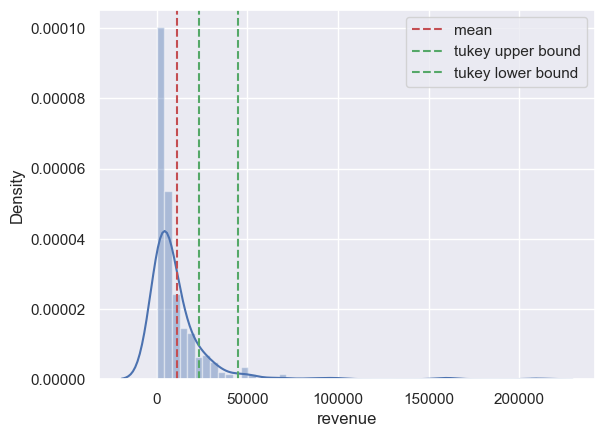

In [77]:
ax = sns.distplot(matched_df['revenue'])
iqr = np.percentile(matched_df['revenue'], 75) - np.percentile(matched_df['revenue'], 25)
upper_bound = np.percentile(matched_df['revenue'], 75) + 3.0 * iqr
lower_bound = np.percentile(matched_df['revenue'], 75) + 1.0 * iqr
ax.axvline(x=np.mean(matched_df['revenue']), color='r', linestyle='--', label='mean')
ax.axvline(x=upper_bound, color='g', linestyle='--', label='tukey upper bound')
ax.axvline(x=lower_bound, color='g', linestyle='--', label='tukey lower bound')
ax.legend()

/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_56411/2735881694.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(matched_df[col])
/opt/homebrew/anaconda3/envs/propensity/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


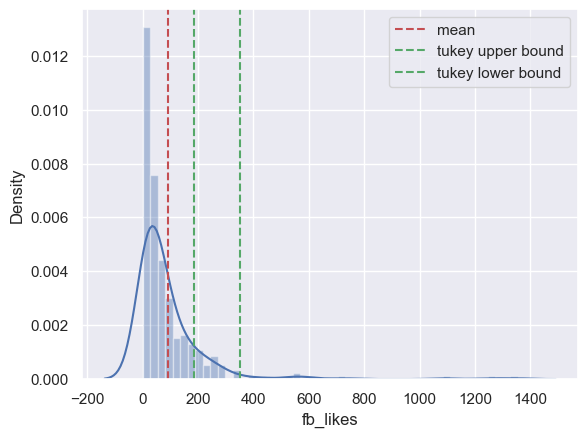

In [78]:
col = 'fb_likes'
ax = sns.distplot(matched_df[col])
iqr = np.percentile(matched_df[col], 75) - np.percentile(matched_df[col], 25)
upper_bound = np.percentile(matched_df[col], 75) + 3.0 * iqr
lower_bound = np.percentile(matched_df[col], 75) + 1.0 * iqr
ax.axvline(x=np.mean(matched_df[col]), color='r', linestyle='--', label='mean')
ax.axvline(x=upper_bound, color='g', linestyle='--', label='tukey upper bound')
ax.axvline(x=lower_bound, color='g', linestyle='--', label='tukey lower bound')
ax.legend()

/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_56411/444103433.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(matched_df[col])
/opt/homebrew/anaconda3/envs/propensity/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


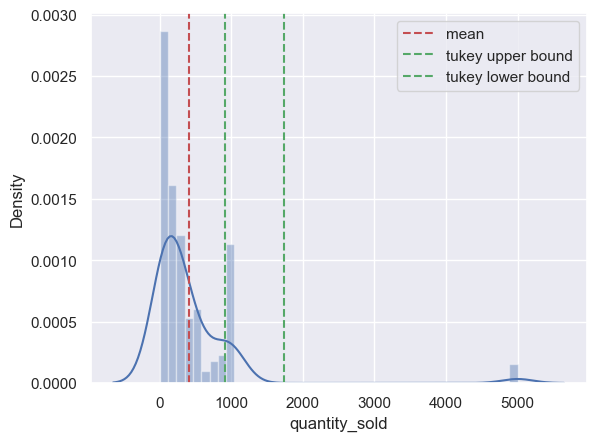

In [80]:
col = 'quantity_sold'
ax = sns.distplot(matched_df[col])
iqr = np.percentile(matched_df[col], 75) - np.percentile(matched_df[col], 25)
upper_bound = np.percentile(matched_df[col], 75) + 3.0 * iqr
lower_bound = np.percentile(matched_df[col], 75) + 1.0 * iqr
ax.axvline(x=np.mean(matched_df[col]), color='r', linestyle='--', label='mean')
ax.axvline(x=upper_bound, color='g', linestyle='--', label='tukey upper bound')
ax.axvline(x=lower_bound, color='g', linestyle='--', label='tukey lower bound')
ax.legend()

## 1.5.3 Evaulate ATE for revenue and compare it to the p-values

In [97]:
treated_df = matched_df[matched_df['treatment'] == 1]
untreated_df = matched_df[(matched_df['treatment'] == 0)].reset_index()
merged_df = pd.merge(treated_df, untreated_df, left_on='matched', right_on='index', suffixes=('_treated', '_untreated'))

In [98]:
np.mean(merged_df['revenue_binary_treated'] - merged_df['revenue_binary_untreated'])

0.04678362573099415